# Deep Neural Network
## Author: John Hennigan
### This notebook generates and tests a model to predict the following years utilization of mental helath services based on the current years Google Trends data

### Features
####

### Target
####

In [142]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, make_scorer, mean_squared_error
from scikeras.wrappers import KerasRegressor
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# work around to load the gsmh package because jupiter notebooks dont want to work with me
file_path = '../gsmhPackage/gsmh_quality.py'
with open(file_path, 'r') as file:
    exec(file.read())




In [143]:
#Custom function to render graphs

def plot_predictions_vs_actual(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs Actual Values')
    plt.show()

#Custom funtion to add features missing in dataset
def add_previous_year_features(df, feature_cols):
    # Sort the DataFrame by state_id and year
    df = df.sort_values(by=['state_id', 'year'])
    
    # Add the previous year's util rate
    df['prev_util_rate'] = df.groupby('state_id')['util_rate'].shift(1)
    
    # List to store new feature columns
    new_feature_cols = ['prev_util_rate']
    
    # Add the previous year's values for each feature column
    for col in feature_cols:
        new_col = f'prev_{col}'
        df[new_col] = df.groupby('state_id')[col].shift(1)
        new_feature_cols.append(new_col)
    new_feature_cols = new_feature_cols + feature_cols

    return df, new_feature_cols

#Create a model, allows for passing of many hyperparameters
def create_model(layers=[64], activations=['relu'], dropout_rates=[0.0], optimizer='adam', learning_rate=0.001, **kwargs):
    model = Sequential()
    for i, neurons in enumerate(layers):
        if i == 0:
            model.add(Dense(neurons, activation=activations[i], input_shape=(X.shape[1],)))
        else:
            model.add(Dense(neurons, activation=activations[i]))
        if i < len(dropout_rates):
            model.add(Dropout(dropout_rates[i]))
    
    model.add(Dense(1)) 
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse')
    return model

#wrapper function to pass best params as a single object
def create_model_from_best_params(params):
    model = create_model(params['model__layers'], params['model__activations'], params['model__dropout_rates'], params['model__optimizer'], params['model__learning_rate'])
    return model

def automatic_feature_selection(X, y, n_features_to_select=12):
    #Remove highly correlated features
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    X_reduced = X.drop(columns=to_drop)

    #Feature Importance using Random Forest
    rf = RandomForestRegressor()
    rf.fit(X_reduced, y)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    important_features_rf = X_reduced.columns[indices[:n_features_to_select]]

    model = LinearRegression()

    # Validate with Cross-Validation
    scores = cross_val_score(model, X_reduced[important_features_rf], y, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean CV score:", np.mean(scores))

    return important_features_rf

In [144]:
#read the data, add a tgt column
df = pd.read_csv("../data/aggregated_data_renamed.csv")
df = df.sort_values(by=['state_id', 'year'])

# Add the tgt_util_rate column which is the util_rate for the state at the following year
df['tgt_util_rate'] = df.groupby('state_id')['util_rate'].shift(-1)
df.to_csv("../data/aggregated_data_with_tgt.csv")
feature_cols = [
    "max_ADHD", "max_PTSD", "max_anxiety", "max_bipolar", "max_depression",
    # "max_mental hospital", "max_psychiatrists near me", "max_psychologist near me", "max_therapist near me",
    "mean_ADHD", "mean_PTSD", "mean_anxiety", "mean_bipolar", "mean_depression",
    # "mean_mental hospital", "mean_psychiatrists near me", "mean_psychologist near me", "mean_therapist near me",
    "median_ADHD", "median_PTSD", "median_anxiety", "median_bipolar", "median_depression",
    # "median_mental hospital", "median_psychiatrists near me", "median_psychologist near me", "median_therapist near me"
]

df, feature_cols = add_previous_year_features(df, feature_cols)

# check_normality(df, feature_cols)

target_col = "tgt_util_rate"
df = df.groupby('state_id').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)
# Drop rows where `tgt_util_rate` is Empty
df = df.dropna(subset=[target_col])

# Split the data into training and testing sets based on the values from Professors formula
X = df[feature_cols]
y = df[target_col]

# Perform feature selection
selected_features = automatic_feature_selection(X, y)
print("Selected features:", selected_features)

X = df[selected_features]



C:\Users\johnb\AppData\Local\Temp\ipykernel_44616\1963474485.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('state_id').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)


Cross-validation scores: [0.84272306 0.80880604 0.94836698 0.67533743 0.80801517]
Mean CV score: 0.8166497351716258
Selected features: Index(['prev_util_rate', 'mean_depression', 'prev_max_depression',
       'prev_mean_depression', 'mean_PTSD', 'prev_max_anxiety',
       'prev_mean_PTSD', 'prev_mean_ADHD', 'prev_max_ADHD', 'max_PTSD',
       'max_anxiety', 'prev_mean_mental hospital'],
      dtype='object')


In [145]:
# Wrap the Keras model so it can be used with scikit-learn
model = KerasRegressor(model=create_model, epochs=50, batch_size=32, verbose=0)

# Define the parameter grid
param_distributions = {
    'model__layers': [[32], [64, 32], [128, 64, 32], [256, 128, 64, 32]],
    'model__activations': [['relu'], ['tanh'], ['relu', 'relu'], ['relu', 'tanh'], ['relu', 'relu', 'tanh'], ['tanh', 'relu'], ['relu', 'relu', 'relu', 'tanh'], ['relu', 'relu', 'relu'], ['tanh', 'relu', 'tanh']],
    'model__dropout_rates': [[0.0], [0.2], [0.2, 0.2], [0.3, 0.3, 0.2], [0.3, 0.3, 0.3, 0.2]],
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'model__learning_rate': [0.001, 0.01, 0.1],
    'epochs' : [10,20,30,40,50,60,70,80,90,100],
    'batch_size' : [16, 32,64]
}


# Standardize the features
Xscaler = StandardScaler()
Yscaler = StandardScaler()

X_scaled = Xscaler.fit_transform(X)
Y_scaled = Yscaler.fit_transform(pd.DataFrame(y))

scorer = make_scorer(mean_squared_error, greater_is_better=False)
# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=100, cv=10, 
                                   verbose=1, n_jobs=-1, random_state=42, scoring=scorer)
random_search_result = random_search.fit(X_scaled,Y_scaled)

# Retrieve the best model and its parameters
best_model = random_search_result.best_estimator_
best_params = random_search_result.best_params_
best_score = random_search_result.best_score_

# Print the results
print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
440 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py", line 9

Best Score: -0.1476627676320891
Best Parameters: {'model__optimizer': 'adam', 'model__learning_rate': 0.001, 'model__layers': [32], 'model__dropout_rates': [0.2], 'model__activations': ['relu', 'relu', 'relu'], 'epochs': 70, 'batch_size': 16}


Epoch 1/70


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4201 - val_loss: 0.9659
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8716 - val_loss: 0.6699
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6430 - val_loss: 0.5290
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5622 - val_loss: 0.4466
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5472 - val_loss: 0.3895
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4700 - val_loss: 0.3481
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4417 - val_loss: 0.3097
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3214 - val_loss: 0.2858
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4447 - val_loss: 0.2659
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2912 - val_loss: 0.2504
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2902 - val_loss: 0.2411
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2783 - val_loss: 0.2402

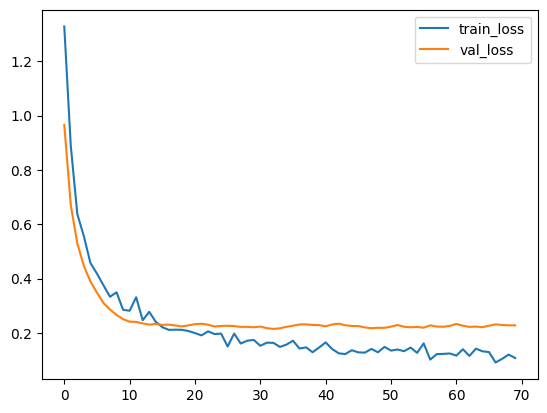

Test R-squared Score: 0.8067849375449441


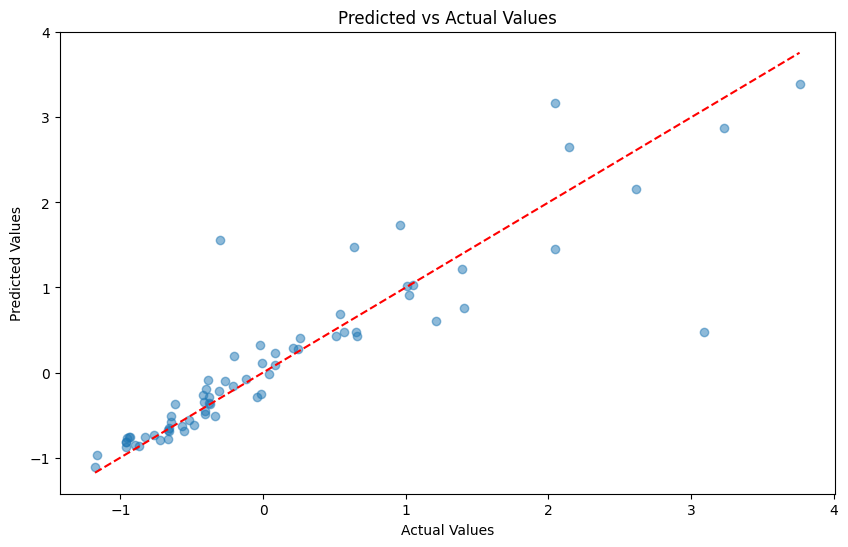

Versus Base Line ----- 
1.1882726415756306
0.22749601522397905
Epoch 1/70


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5297 - val_loss: 0.9419
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1154 - val_loss: 0.7330
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0956 - val_loss: 0.5923
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7128 - val_loss: 0.4970
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5600 - val_loss: 0.4141
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4354 - val_loss: 0.3555
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4955 - val_loss: 0.3116
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3612 - val_loss: 0.2701
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3100 - val_loss: 0.2438
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3005 - val_loss: 0.2270
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2821 - val_loss: 0.2125
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3087 - val_loss: 0.2021


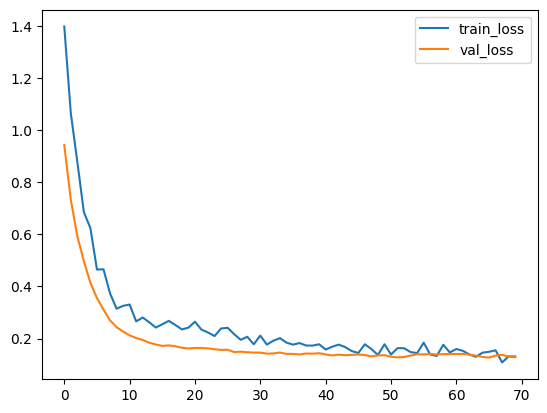

Test R-squared Score: 0.8620357645158946


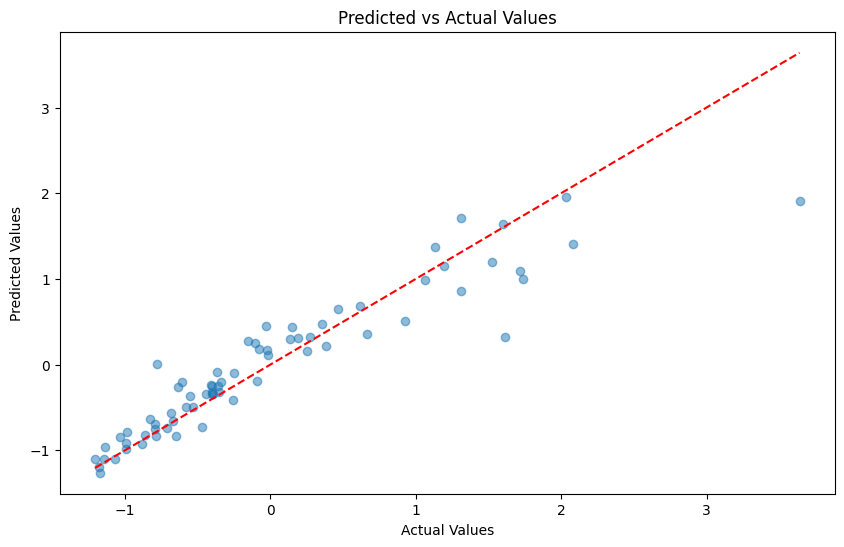

Versus Base Line ----- 
0.9575563897427027
0.13206448578595317
Epoch 1/70


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2982 - val_loss: 1.3513
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7906 - val_loss: 0.9800
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2785 - val_loss: 0.7573
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2220 - val_loss: 0.6022
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0438 - val_loss: 0.4861
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8070 - val_loss: 0.4063
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5542 - val_loss: 0.3508
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5665 - val_loss: 0.3069
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5353 - val_loss: 0.2642
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3407 - val_loss: 0.2355
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3422 - val_loss: 0.2118
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3097 - val_loss: 0.1963


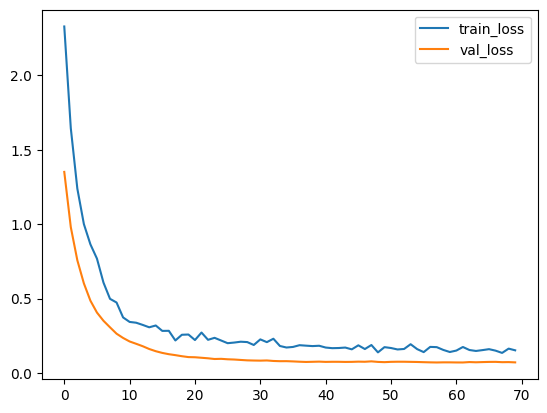

Test R-squared Score: 0.9078938030545713


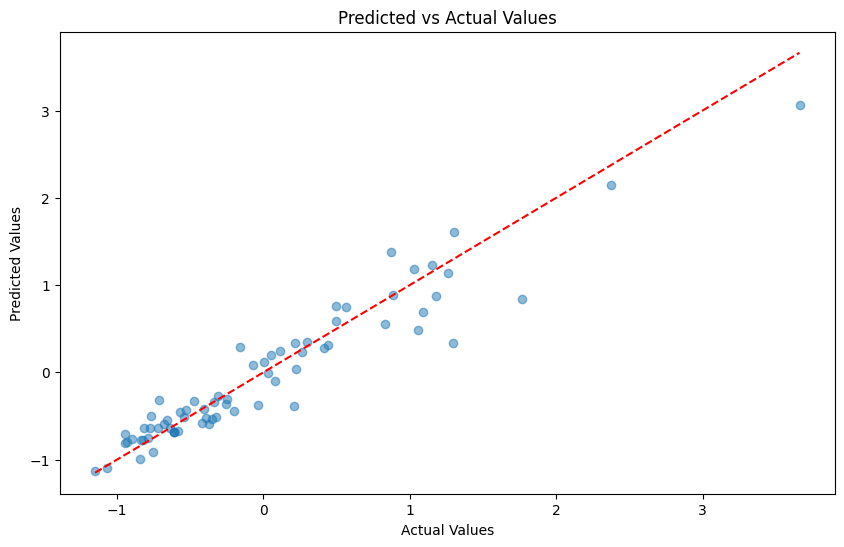

Versus Base Line ----- 
0.7745257091444108
0.07133204028023678
Epoch 1/70


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3258 - val_loss: 0.8029
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8559 - val_loss: 0.6987
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7455 - val_loss: 0.6061
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6673 - val_loss: 0.5219
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4862 - val_loss: 0.4655
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5138 - val_loss: 0.4274
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5424 - val_loss: 0.3680
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4457 - val_loss: 0.3296
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3300 - val_loss: 0.2955
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2984 - val_loss: 0.2588
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2661 - val_loss: 0.2333
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3045 - val_loss: 0.1995

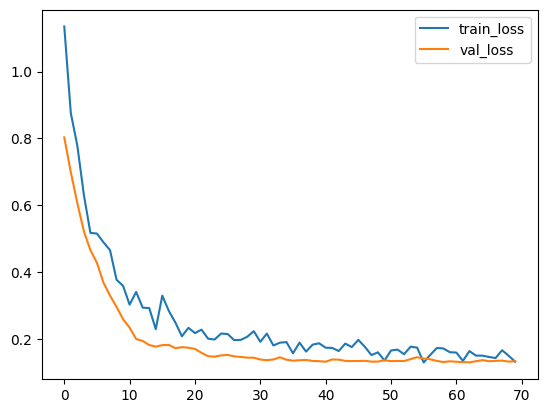

Test R-squared Score: 0.8956269295315565


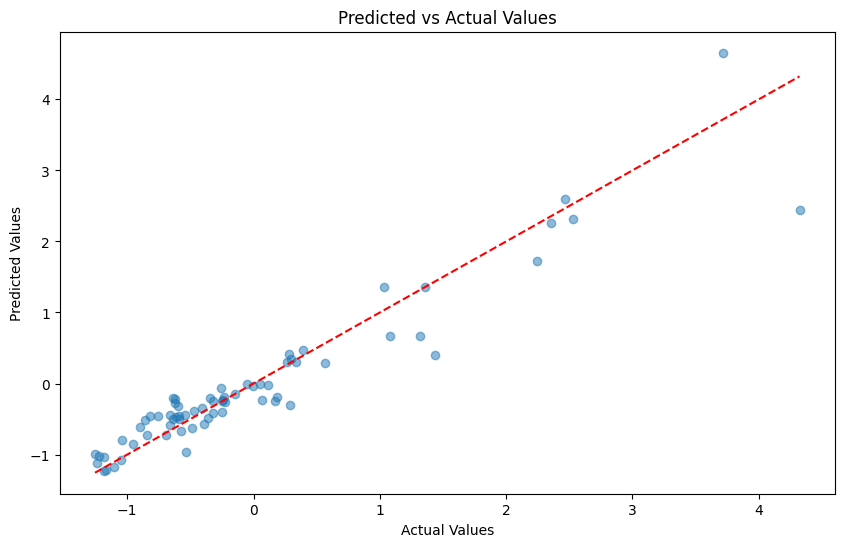

Versus Base Line ----- 
1.2739512014020093
0.13287348537572063
Epoch 1/70


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3807 - val_loss: 1.0974
Epoch 2/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3629 - val_loss: 0.8845
Epoch 3/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0008 - val_loss: 0.7655
Epoch 4/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8275 - val_loss: 0.6734
Epoch 5/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7913 - val_loss: 0.5898
Epoch 6/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7827 - val_loss: 0.5191
Epoch 7/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6243 - val_loss: 0.4599
Epoch 8/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5238 - val_loss: 0.4157
Epoch 9/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5102 - val_loss: 0.3779
Epoch 10/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4960 - val_loss: 0.3444
Epoch 11/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4162 - val_loss: 0.3184
Epoch 12/70
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3600 - val_loss: 0.2998


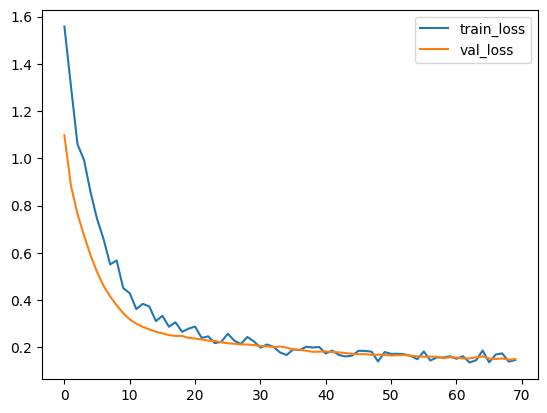

Test R-squared Score: 0.8229412921532274


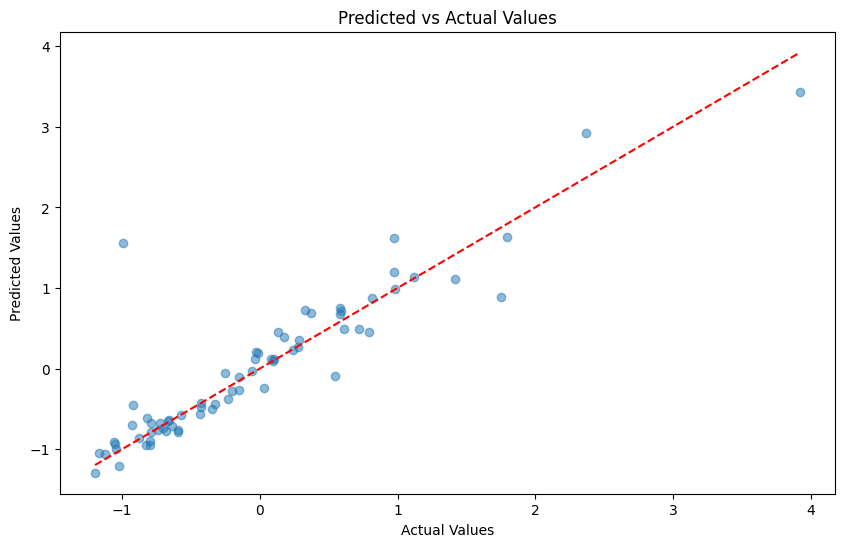

Versus Base Line ----- 
0.8490428376706151
0.14994355020443517


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_184 (Dense)               │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,349 (5.27 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 900 (3.52 KB)

None
{'model__optimizer': 'adam', 'model__learning_rate': 0.001, 'model__layers': [32], 'model__dropout_rates': [0.2], 'model__activations': ['relu', 'relu', 'relu'], 'epochs': 70, 'batch_size': 16}
Index(['prev_util_rate', 'mean_depression', 'prev_max_depression',
       'prev_mean_depression', 'mean_PTSD', 'prev_max_anxiety',
       'prev_mean_PTSD', 'prev_mean_ADHD', 'prev_max_ADHD', 'max_PTSD',
       'max_anxiety', 'prev_mean_mental hospital'],
      dtype='object')
Average R2 : 0.8590565453600387


In [146]:
#prep the model and data

# Initialize KFold and Scaler
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
Xscaler = StandardScaler()
Yscaler = StandardScaler()

# Initialize lists to store actual and predicted values
actuals = []
predictions = []

# Initialize KFold and Scaler
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
for train_index, test_index in k_folds.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    # Standardize the data
    X_train = Xscaler.fit_transform(X_train)
    X_test = Xscaler.transform(X_test)
    y_train = Yscaler.fit_transform(y_train).flatten()
    y_test = Yscaler.transform(y_test).flatten()
    
    model = create_model_from_best_params(best_params)
    # Train the model
    history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test))

    # Make predictions
    y_pred = model.predict(X_test)

    #plot training history
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

    r2 = r2_score(y_test, y_pred)
    print(f'Test R-squared Score: {r2}')
    r2_scores.append(r2)

    plot_predictions_vs_actual(y_test, y_pred.flatten())
    score = r2_score(y_test, y_pred)
    baseline_pred = np.mean(y_train) * np.ones_like(y_test) 
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    print("Versus Base Line ----- ")
    print(baseline_mse)
    print(mean_squared_error(y_test, y_pred))

    residuals_nn = y_test - y_pred.squeeze() 
    residuals_baseline = y_test - baseline_pred 
    t_stat, p_value = stats.ttest_rel(residuals_nn, residuals_baseline)
    if p_value < 0.05:
        print("REJECTING NULL HYPOTHESIS")

print(model.summary())
print(best_params)
print(X.keys())
print(f"Average R2 : {sum(r2_scores)/len(r2_scores)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


 len of residuals
348


 len of predictions
348


c:\Users\johnb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


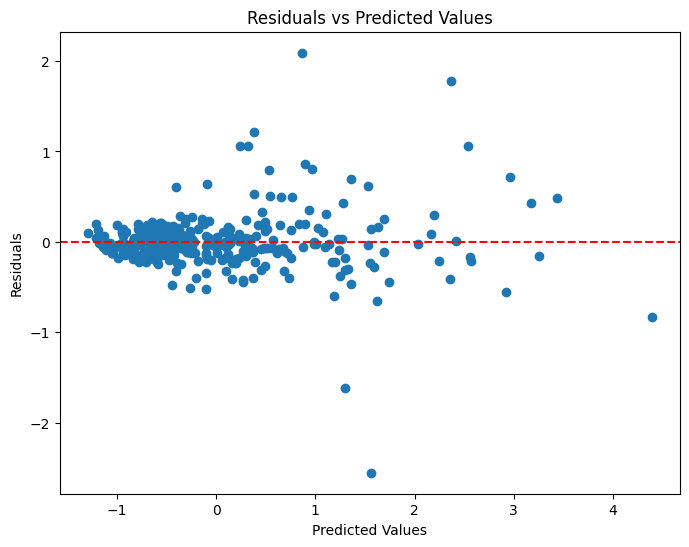

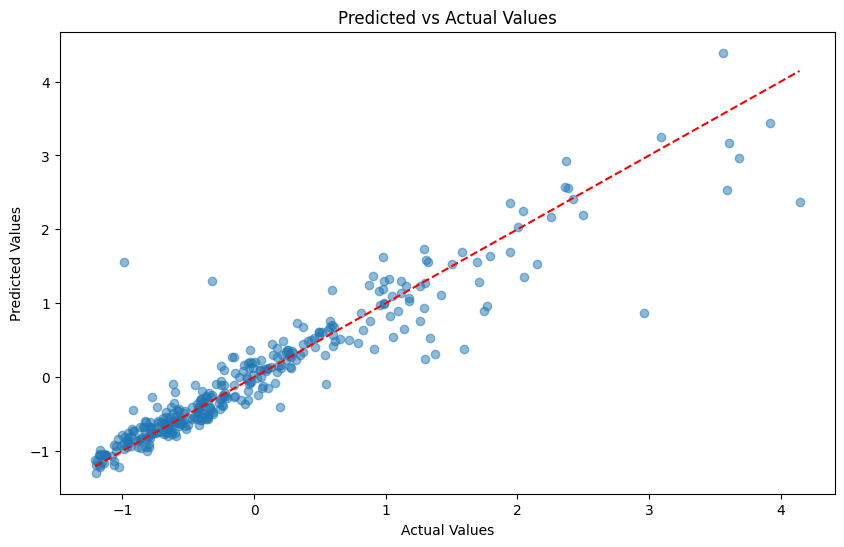

0.10732041213152049


In [147]:
#reusing some code to test on full dataset
# Standardize the data
scaler = StandardScaler()
X_check = Xscaler.transform(X)
pred = model.predict(X_check)

targets = df[target_col].values
targets = Yscaler.transform(targets.reshape(-1, 1)).flatten()

# print(len(targets))
check_homoscedasticity(targets, pred.flatten().tolist())
plot_predictions_vs_actual(targets, pred.flatten())

print(mean_squared_error(targets, pred))


Index(['prev_util_rate', 'mean_depression', 'prev_max_depression',
       'prev_mean_depression', 'mean_PTSD', 'prev_max_anxiety',
       'prev_mean_PTSD', 'prev_mean_ADHD', 'prev_max_ADHD', 'max_PTSD',
       'max_anxiety', 'prev_mean_mental hospital'],
      dtype='object')
0.8893584537090786


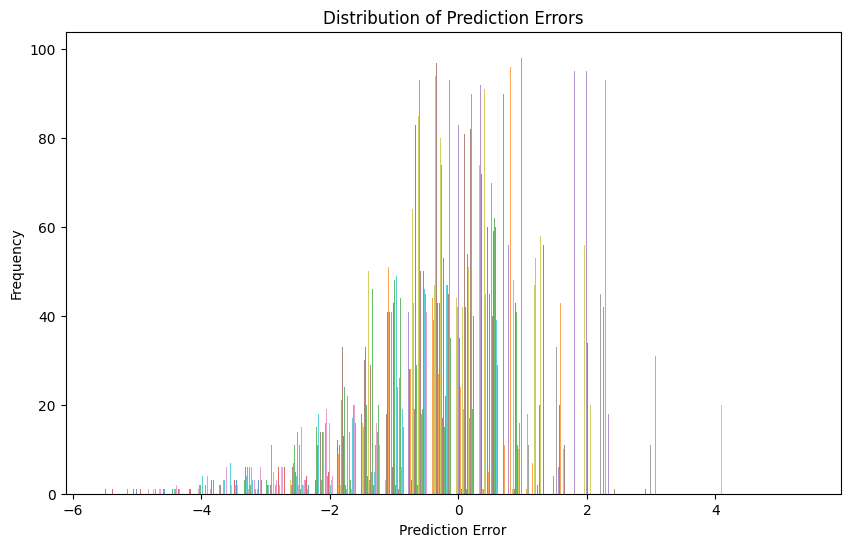

In [148]:
#Just used to make distribution graph and print few values used in the final report
print(selected_features)
r2 = r2_score(targets, pred)
print(r2)


errors = targets - pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

